In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import albumentations as A
import torch
import torchvision
import os
from pathlib import Path

from facenet_pytorch import MTCNN
from albumentations.augmentations.crops.transforms import Crop
from PIL import Image

In [46]:
train_df =  pd.read_csv('/opt/ml/input/data/train/new_train.csv')
train_df

,id,mask,gender,age,totalLabel,customLabel,useMask,isCorrect,actualAge,ageModTen,errorM,errorG,errorA,error,isAug,path
0,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
1,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
2,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
3,000001,1,1,1,10,22,1,0,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
4,000001,2,1,1,16,34,0,-1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18895,006959,0,0,0,0,1,1,1,19,1,0,0,0,0,0,/opt/ml/input/data/train/images/006959_male_As...
18896,006959,1,0,0,6,13,1,0,19,1,0,0,0,0,0,/opt/ml/input/data/train/images/006959_male_As...
18897,006959,2,0,0,12,25,0,-1,19,1,0,0,0,0,0,/opt/ml/input/data/train/images/006959_male_As...
18898,006959,0,0,0,0,1,1,1,19,1,0,0,0,0,0,/opt/ml/input/data/train/images/006959_male_As...


## Imbalance 파악 -> Horizental Mix

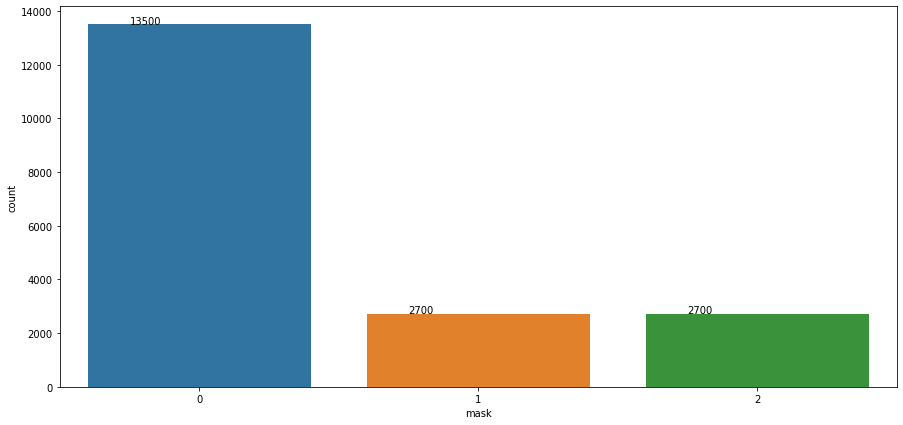

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax = sns.countplot(x="mask", data=train_df, ax=ax)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+30))

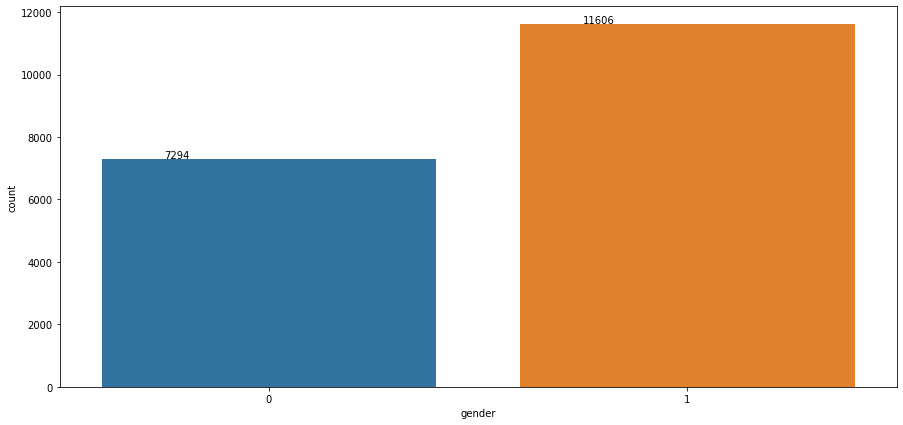

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax = sns.countplot(x="gender", data=train_df, ax=ax)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+30))

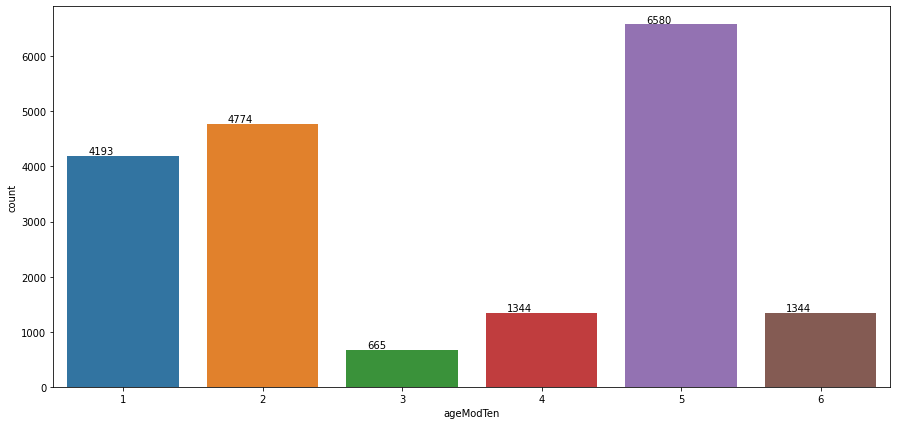

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax = sns.countplot(x="ageModTen", data=train_df, ax=ax)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+30))

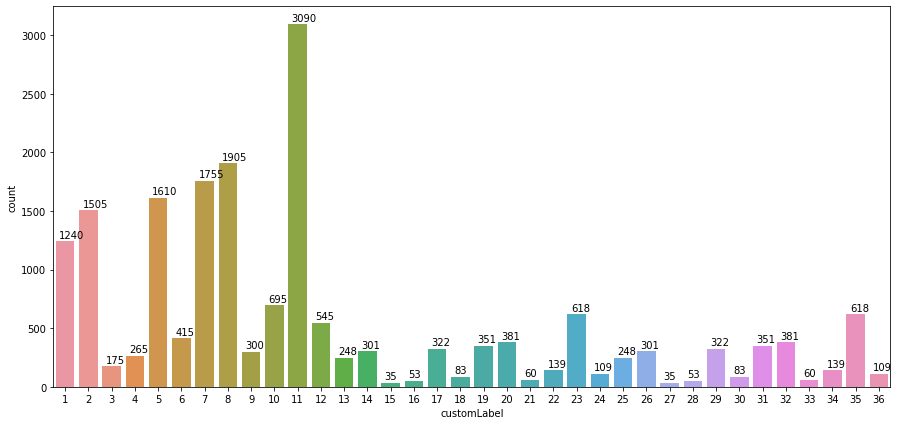

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax = sns.countplot(x="customLabel", data=train_df, ax=ax)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+30))

### 위 그래프에서 

In [164]:
augu_df = pd.DataFrame(None, columns = ['id', 'mask', 'gender', 'age',  'totalLabel', 'customLabel', 'useMask', 'isCorrect', 'actualAge', 'ageModTen', 'errorM', 'errorG', 'errorA', 'error', 'isAug', 'path'])
out_path = '/opt/ml/input/data/train/train_augu2.csv'

In [165]:
detector = MTCNN()
goal = 618
img_ori_dir = Path('/opt/ml/input/data/train')

for label in range(25, 37):
    target_df = train_df[(train_df.customLabel == label)]
    target_path_li = target_df['path'].tolist()
    target_idx_li = list(target_df.index)

    cur_label_count = len(target_path_li) # 해당 label augu 전 수
    quota = goal - cur_label_count # 만들어야 하는 수
    ratio = quota
    
    if(quota == 0):
        continue
    jump = int(cur_label_count * (cur_label_count - 1) / quota) # 점프
    count = -1
    success = 0
    iterCount = 0
    
    while(success < quota):
        for i in range(cur_label_count-1):
            if(success >= quota): break
            if(i%30 ==0): print(f'label : {label}, {i}번째 이미지 처리중') # 디버깅 
            
            for j in range(i+1,cur_label_count):
                count += 1
                if(count % jump != 0):
                    continue
                
                img1 = Image.open(target_path_li[i].replace('images', 'images_face_crop'))
                img2 = Image.open(target_path_li[j].replace('images', 'images_face_crop'))
                new_img = Image.fromarray(np.concatenate((np.array(img1)[:,:112,:], np.array(img2)[:,112:,:]), axis=1)) # image mix
                
                face = detector.detect(new_img) # 얼굴인지 확인
                
                if(face[1][0] != None): #얼굴이면
                    success += 1
                    img_info1 = target_df.loc[target_idx_li[i]]
                    img_info2 = target_df.loc[target_idx_li[j]]
                    normal_id = img_info1['id'][2:] + img_info2['id'][2:]
                    gender = 'male' if img_info1['gender'] == 0 else 'female'
                    actualAge = (img_info1['actualAge'] + img_info2['actualAge']) // 2
                    profile = f'{normal_id}_{gender}_Asian_{actualAge}'
                    new_path = img_ori_dir / Path('images') / Path(profile)
                    for target_data in ['images_face_crop', 'images_seg_crop', 'images_seg_crop_upper_face']:
                        img1 = Image.open(target_path_li[i].replace('images', target_data))
                        img2 = Image.open(target_path_li[j].replace('images', target_data))
                        new_img = Image.fromarray(np.concatenate((np.array(img1)[:,:112,:], np.array(img2)[:,112:,:]), axis=1))
                        parent_dir = img_ori_dir / Path(target_data) / Path(profile)
                        if not os.path.isdir(parent_dir):
                            os.makedirs(parent_dir)
                        new_img.save(parent_dir / Path('normal.jpg'))
                    data = {
                        'id': normal_id,
                        'mask': img_info1['mask'],
                        'gender': img_info1['gender'],
                        'age': img_info1['age'],
                        'useMask': img_info1['useMask'],
                        'isCorrect': img_info1['isCorrect'],
                        'actualAge': actualAge,
                        'ageModTen' : img_info1['ageModTen'],
                        'errorM': 0,
                        'errorG': 0,
                        'errorA': 0,
                        'error': 0,
                        'totalLabel': img_info1['totalLabel'],
                        'customLabel': img_info1['customLabel'],
                        'isAug': 1,
                        'path': str(new_path / Path('normal.jpg'))
                    }
                    augu_df = augu_df.append(data, ignore_index=True)
                    
                    # -- incorrect
                    for target_data in ['images_face_crop', 'images_seg_crop', 'images_seg_crop_upper_face']:
                        img1_path = list(train_df[(train_df.id == img_info1['id']) & (train_df['mask'] == 1)]['path'])[0].replace('images', target_data)
                        img2_path = list(train_df[(train_df.id == img_info2['id']) & (train_df['mask'] == 1)]['path'])[0].replace('images', target_data)
                        img1 = Image.open(img1_path)
                        img2 = Image.open(img2_path)
                        new_img = Image.fromarray(np.concatenate((np.array(img1)[:,:112,:], np.array(img2)[:,112:,:]), axis=1))
                        
                        parent_dir = img_ori_dir / Path(target_data) / Path(profile)
                        new_img.save(parent_dir / Path('incorrect_mask.jpg'))
                    
                    data = {
                        'id': normal_id,
                        'mask': 1,
                        'gender': img_info1['gender'],
                        'age': img_info1['age'],
                        'useMask': 1,
                        'isCorrect': 0,
                        'actualAge': actualAge,
                        'ageModTen' : img_info1['ageModTen'],
                        'errorM': 0,
                        'errorG': 0,
                        'errorA': 0,
                        'error': 0,
                        'totalLabel': img_info1['totalLabel'] - 6,
                        'customLabel': img_info1['customLabel'] - 12,
                        'isAug': 1,
                        'path': str(new_path / Path('incorrect_mask.jpg'))
                    }
                    augu_df = augu_df.append(data, ignore_index=True)

                    for k in range(1, 6):
                        for target_data in ['images_face_crop', 'images_seg_crop', 'images_seg_crop_upper_face']:
                            
                            img1_mask_path = list(train_df[(train_df.id == img_info1['id']) & (train_df['mask'] == 0)]['path'])[k-1].replace('images', target_data)
                            img2_mask_path = list(train_df[(train_df.id == img_info2['id']) & (train_df['mask'] == 0)]['path'])[k-1].replace('images', target_data)

                            img1 = Image.open(img1_mask_path)
                            img2 = Image.open(img2_mask_path)
                            new_img = Image.fromarray(np.concatenate((np.array(img1)[:,:112,:], np.array(img2)[:,112:,:]), axis=1))

                            parent_dir = img_ori_dir / Path(target_data) / Path(profile)
                            new_img.save(parent_dir / Path(f'mask{k}.jpg'))

                        data = {
                            'id': normal_id,
                            'mask': 0,
                            'gender': img_info1['gender'],
                            'age': img_info1['age'],
                            'useMask': 1,
                            'isCorrect': 1,
                            'actualAge': actualAge,
                            'ageModTen' : img_info1['ageModTen'],
                            'errorM': 0,
                            'errorG': 0,
                            'errorA': 0,
                            'error': 0,
                            'totalLabel': img_info1['totalLabel'] - 12,
                            'customLabel': img_info1['customLabel'] - 24,
                            'isAug': 1,
                        'path': str(new_path / Path(f'mask{k}.jpg'))
                        }
                        augu_df = augu_df.append(data, ignore_index=True)
                                         
                    if(success >= quota):
                        break
        iterCount += 1
        print(f'label : {label}, {iterCount} 번 쨰 도는 중... {success} / {quota} 진행중')
        
        ratio = ratio + random.randint(1, 5)
        jump = int(cur_label_count * (cur_label_count - 1) / ratio) # 점프
    print(f'label : {label} 완료 ')
print(len(augu_df))

label : 25, 0번째 이미지 처리중
label : 25, 30번째 이미지 처리중
label : 25, 60번째 이미지 처리중
label : 25, 90번째 이미지 처리중
label : 25, 120번째 이미지 처리중
label : 25, 150번째 이미지 처리중
label : 25, 180번째 이미지 처리중
label : 25, 210번째 이미지 처리중
label : 25, 240번째 이미지 처리중
label : 25, 1 번 쨰 도는 중... 186 / 370 진행중
label : 25, 0번째 이미지 처리중
label : 25, 30번째 이미지 처리중
label : 25, 60번째 이미지 처리중
label : 25, 90번째 이미지 처리중
label : 25, 120번째 이미지 처리중
label : 25, 150번째 이미지 처리중
label : 25, 180번째 이미지 처리중
label : 25, 210번째 이미지 처리중
label : 25, 2 번 쨰 도는 중... 370 / 370 진행중
label : 25 완료 
label : 26, 0번째 이미지 처리중
label : 26, 30번째 이미지 처리중
label : 26, 60번째 이미지 처리중
label : 26, 90번째 이미지 처리중
label : 26, 120번째 이미지 처리중
label : 26, 150번째 이미지 처리중
label : 26, 180번째 이미지 처리중
label : 26, 210번째 이미지 처리중
label : 26, 240번째 이미지 처리중
label : 26, 270번째 이미지 처리중
label : 26, 1 번 쨰 도는 중... 159 / 317 진행중
label : 26, 0번째 이미지 처리중
label : 26, 30번째 이미지 처리중
label : 26, 60번째 이미지 처리중
label : 26, 90번째 이미지 처리중
label : 26, 120번째 이미지 처리중
label : 26, 150번째 이미지 처리중
label : 26, 180번째 이미지 처리중
l

In [166]:
augu_df.to_csv(out_path, index=False)

In [150]:
print(augu_df[(augu_df['isAug'] == 1) & (augu_df['isCorrect'] == 0)]['path'])

1        /opt/ml/input/data/train/images/06851014_male_...
8        /opt/ml/input/data/train/images/06856626_male_...
15       /opt/ml/input/data/train/images/10146142_male_...
22       /opt/ml/input/data/train/images/10231042_male_...
29       /opt/ml/input/data/train/images/10236646_male_...
                               ...                        
32978    /opt/ml/input/data/train/images/43564477_femal...
32985    /opt/ml/input/data/train/images/43635453_femal...
32992    /opt/ml/input/data/train/images/43844456_femal...
32999    /opt/ml/input/data/train/images/43865412_femal...
33006    /opt/ml/input/data/train/images/44564476_femal...
Name: path, Length: 4716, dtype: object


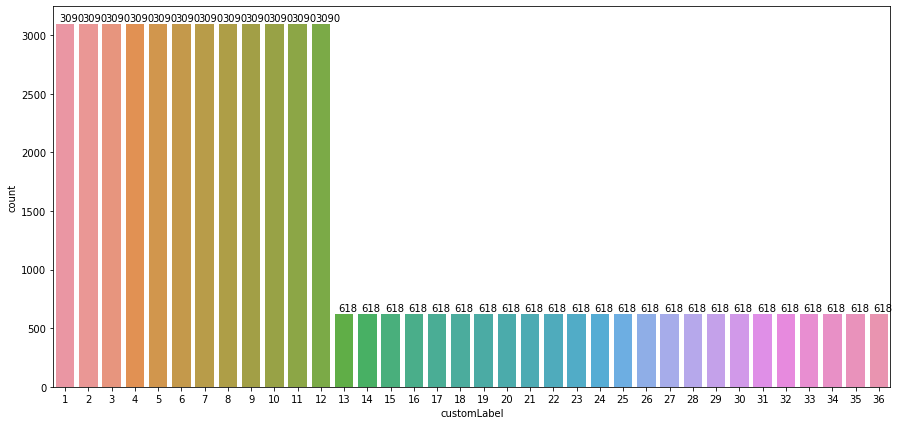

In [170]:
concat_df = pd.concat([train_df, augu_df])
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax = sns.countplot(x="customLabel", data=concat_df, ax=ax)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+30))

In [171]:
concat_path = '/opt/ml/input/data/train/train_augu_concat.csv'
concat_df.to_csv(concat_path, index=False)

In [172]:
concat_df = pd.read_csv(concat_path)
concat_df

,id,mask,gender,age,totalLabel,customLabel,useMask,isCorrect,actualAge,ageModTen,errorM,errorG,errorA,error,isAug,path
0,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
1,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
2,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
3,000001,1,1,1,10,22,1,0,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
4,000001,2,1,1,16,34,0,-1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51907,43125025,0,1,2,5,12,1,1,60,6,0,0,0,0,1,/opt/ml/input/data/train/images/43125025_femal...
51908,43125025,0,1,2,5,12,1,1,60,6,0,0,0,0,1,/opt/ml/input/data/train/images/43125025_femal...
51909,43125025,0,1,2,5,12,1,1,60,6,0,0,0,0,1,/opt/ml/input/data/train/images/43125025_femal...
51910,43125025,0,1,2,5,12,1,1,60,6,0,0,0,0,1,/opt/ml/input/data/train/images/43125025_femal...


In [173]:
# for line in concat_df.iloc:
#     if(line['isAug'] == 1 and line['isCorrect'] == 0):
#         path = line['path']
        
#         line['path'] = line['path'].replace('incorrect.jpg', 'incorrect_mask.jpg')
#         print(str(line['path']))
#         break

concat_df[(concat_df.isAug == 1) & (concat_df['mask'] == 1)]['path'].tolist()

['/opt/ml/input/data/train/images/06851014_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/06856626_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10146142_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10231042_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10236646_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10256206_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10371215_male_Asian_18/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10376660_male_Asian_18/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10426222_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10454202_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10456677_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10506368_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/10775231_male_Asian_19/incorre

In [112]:
concat_df

,id,mask,gender,age,totalLabel,customLabel,useMask,isCorrect,actualAge,ageModTen,errorM,errorG,errorA,error,isAug,path
0,1,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
1,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
2,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
3,000001,1,1,1,10,22,1,0,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
4,000001,2,1,1,16,34,0,-1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33007,44564476,0,1,2,5,12,1,1,60,6,0,0,0,0,1,/opt/ml/input/data/train/images/44564476_femal...
33008,44564476,0,1,2,5,12,1,1,60,6,0,0,0,0,1,/opt/ml/input/data/train/images/44564476_femal...
33009,44564476,0,1,2,5,12,1,1,60,6,0,0,0,0,1,/opt/ml/input/data/train/images/44564476_femal...
33010,44564476,0,1,2,5,12,1,1,60,6,0,0,0,0,1,/opt/ml/input/data/train/images/44564476_femal...


In [ ]:
# NUM_SHOW = 4
# TOTAL = NUM_SHOW * NUM_SHOW

# plt.figure(figsize=(20,25))

# start_idx = np.random.randint(0,len(maleAged_df) - TOTAL)
# cnt = 1
# for idx in range(start_idx, start_idx + TOTAL):
#     img_path = (maleAged_df.iloc[idx]['path']).replace('images', 'images_face_crop')
#     img = Image.open(img_path)
#     plt.subplot(NUM_SHOW, NUM_SHOW, cnt)
#     plt.imshow(img)
#     plt.axis('off')
#     cnt += 1
# plt.plot()

In [ ]:
augu_df['path'].tolist()

In [ ]:
li = maleAged_df['path'].tolist()
faces = random.choices(li, k=2)

In [ ]:
img1 = Image.open(faces[0].replace('images', 'images_face_crop'))
img2 = Image.open(faces[1].replace('images', 'images_face_crop'))
new_img = Image.fromarray(np.concatenate((np.array(img)[:,:112,:], np.array(img2)[:,112:,:]), axis=1))
plt.imshow(new_img)

detector = MTCNN()
face = detector.detect(new_img)
print(face)